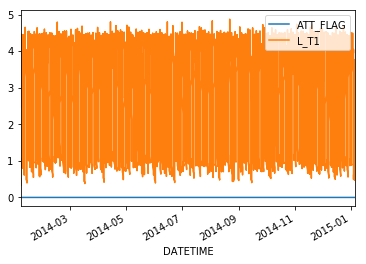

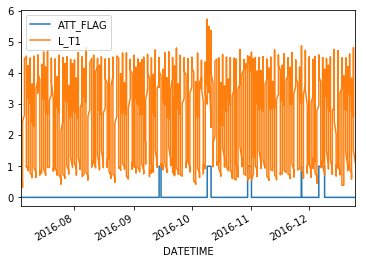

In [99]:
from pandas import read_csv
from pandas import datetime
import pandas
from nltk import ngrams
import math
from matplotlib import pyplot
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import robust_scale
import time
from sklearn.decomposition import PCA
import scipy.stats
import matplotlib.pyplot as plt
from  sklearn.metrics import confusion_matrix
from numpy import linalg as LA
import numpy as np
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1['ATT_FLAG'] = -df_1['ATT_FLAG']/1000 + 1/1000
df_2['ATT_FLAG'] = 1-(-df_2['ATT_FLAG']/1000 + 1/1000)
cols = ['ATT_FLAG', 'L_T1']
df_1.plot(x='DATETIME', y= cols)
df_2.plot(x='DATETIME', y= cols)
pyplot.show()
np.set_printoptions(precision=3,suppress=True)


In [100]:
def convert_df(df, norm=True) :
    labels = df['ATT_FLAG'].values
    x_df = df.drop('ATT_FLAG',1).drop('DATETIME', 1)
    x = x_df.values
    (n,m) = x.shape
    if norm:
        x = robust_scale(x)
    return (x, labels, n,m)


(x_1, y_1, n_1, m_1) = convert_df(df_1)
(x_2, y_2, n_2, m_2) = convert_df(df_2)

# PCA Task:

In [101]:
#Splits principal axes in normal and anomalous sets
#Outputs index of column which first exceeds the threshold
#x_norm: normalized sensor data
#t: threshold value
#m: amount of sensors
def seperate_anomalous(x_norm,t,m):
    i = 0
    for i in range(0, m):
        u = x_norm[:,i]
        mu = np.mean(u)
        std = math.sqrt(np.std(u))
        t_min = mu-(std*t)
        t_max = mu+(std*t)
        breach= np.any(u<t_min) or np.any(u>t_max)
        if breach:
            break
    return i

#Calculates the Squared Prediction Error for all residual data
#x_a: residual sensor datamatric
#n: amount of datapoints
def calc_SPE(x_a,n):
    spes = np.empty([n])
    for i in range(0,n):
        y = x_a[:,i] 
        spes[i] = np.dot(y, y.T)
    return spes

#Calculates the Q-statistic on the residual data
#alpha: confidence rate
#x: sensordata
#comps: component vectors of the pca
#r: amount of normal component vectors
#m: amount of sensors
def calc_q_stat(alpha, x, comps,r,m):
    phi_1 = calc_phi(1,m,r,x,comps)
    phi_2 = calc_phi(2,m,r,x,comps)
    phi_3 = calc_phi(3,m,r,x,comps)
    h_0 = 1 - ((2*phi_1*phi_3)/(3*phi_2**2))
    c_a = scipy.stats.norm.ppf(1-alpha)
    
    left_part = c_a * math.sqrt(2*phi_2* h_0**2)/phi_1
    right_part = phi_2* h_0*(h_0-1) /phi_1**2 
    
    center_part = left_part+1+right_part

    d2_a = phi_1 * center_part**(1/h_0)
    return d2_a

#Helper function for calculating the Q-statistic 
def calc_phi(i,m,r,x,comps):  
    res = 0
    for j in range(r+1,m):
        v_j = comps[:,j]
        xv = np.dot(x,v_j)
        l_j = LA.norm(xv)
        res = res + l_j**i
    return res

#Initiates the PCA-based anomality detection on the given dataset 
#Outputs a list of all datapoints deemed as anomality
#alpha: confidence rate
#x: sensor data
#y sensor labels
#n amount of datapoints
#m: amount of sensors
#t: threshold value

def init_pca(n,m,x,y,alpha,t):
    pca = PCA(n_components=m)
    pca.fit(x)
    proj_x = pca.transform(x)
    norm_x = normalize(proj_x, norm='l1', axis=0)
    idx =  seperate_anomalous(norm_x, t,m)  
    r= idx-1
    prin_comps = pca.components_
    P = prin_comps[:,0:r]
    C = np.dot(P, P.T)
    I = np.identity(m)

    x_n = np.dot(C, x.T)
    x_a = np.dot(I-C, x.T)
    spes = calc_SPE(x_a,n)
    q_stat = calc_q_stat(alpha, x_2, prin_comps,r,m)
    abnomal = spes > q_stat
    return abnomal

#Tunes threshold and alpha values on given dataset   
def tune_params(cand_alpha,cand_t,n,m,x,y):
    best_t = 0
    best_a = 0
    fp_v = n*m

    for alpha in cand_alpha:
        for t in cand_t:
            pred_y = init_pca(n, m, x, y, alpha,t)
            #print("Alpha: " +str(alpha))
            #print("threshold: "+ str(t))
            #print(confusion_matrix(y, pred_y))
            tn, fp, fn, tp = confusion_matrix(y, pred_y).ravel()
            if fp < fp_v:
                best_t = t
                best_a = alpha
                fp_v = fp 
    return (best_t, best_a)

C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in grea

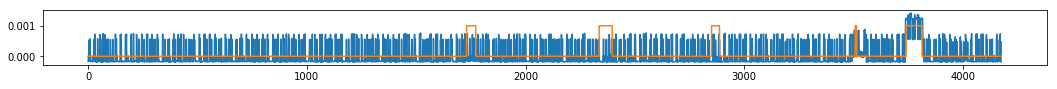

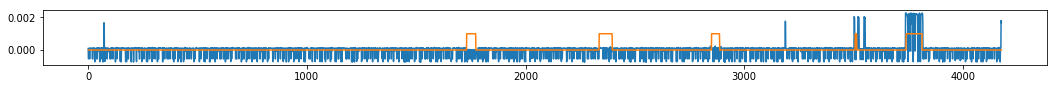

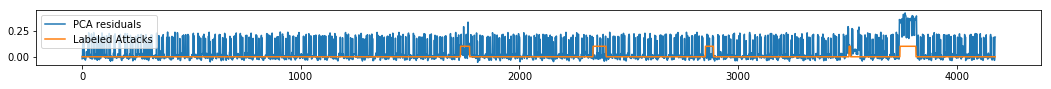

In [141]:
#Test dataset2 and tune the parameters
cand_alpha = [0.5, 0.75, 0.9, 0.99,0.999]
cand_t = [0.5, 1, 2,3,5,10,25, 50]
x =x_2
y = y_2
m = m_2
n = n_2
dates = df_2['DATETIME'].values

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

#Plot the first two principal axes for reference
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.plot(y/1000)

plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])
plt.plot(y/1000)

(t,a) = tune_params(cand_alpha, cand_t, n, m, x, y)
idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)
#Plot the redidual part
plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])
plt.plot(y/10)
plt.legend(["PCA residuals", "Labeled Attacks"],loc=0)




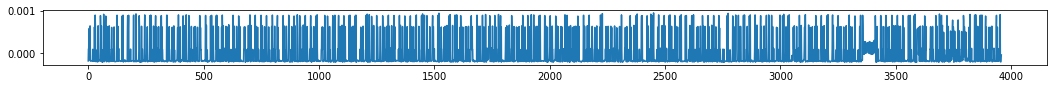

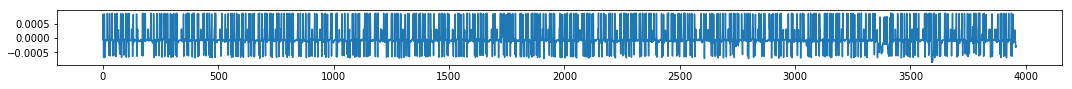

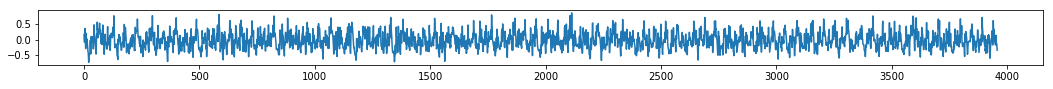

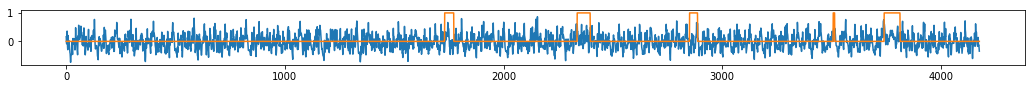

In [140]:
#Test dataset2 with removed abnomalities/points labeled as attack
clean_x = x_2[y_2==0 ,:]
clean_y = y_2[y_2==0]
x = clean_x
y = clean_y
(n,m) = clean_x.shape

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

#Plot the first two principal axes for reference
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)
#Plot the redidual part
plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])

x_2_a = np.dot(I-C, x_2.T)
plt.figure(figsize=(18,1))
plt.plot(x_2_a[0,:])
plt.plot(y_2)


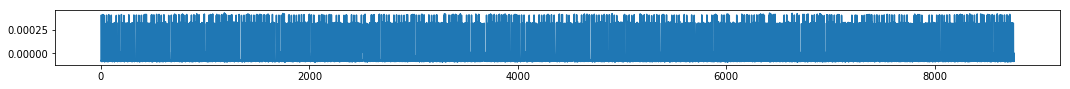

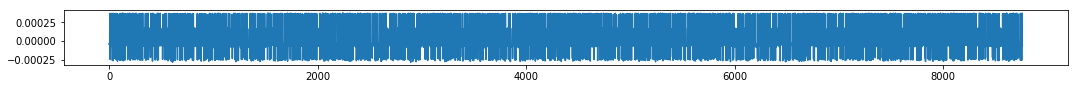

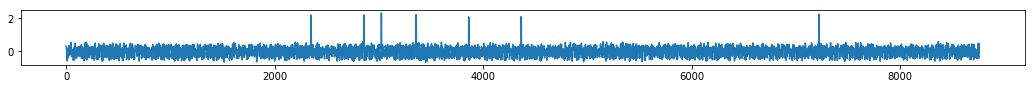

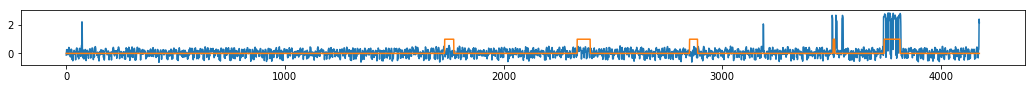

In [120]:
#Test dataset 1
x = x_1
y = y_1
(n,m) = x.shape

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)

plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])

x_2_a = np.dot(I-C, x_2.T)
plt.figure(figsize=(18,1))
plt.plot(x_2_a[0,:])
plt.plot(y_2)


# Discrete models task

C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


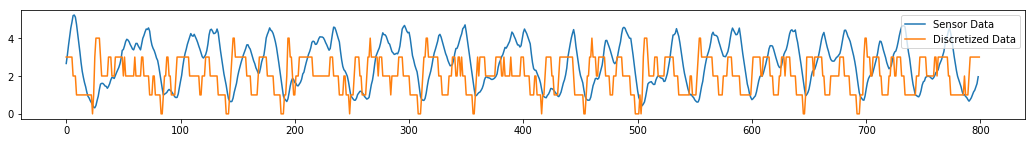

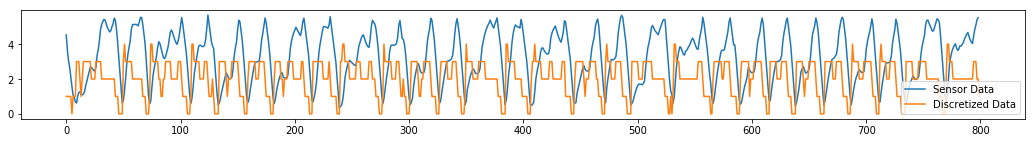

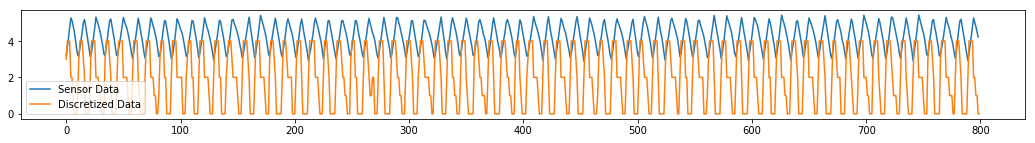

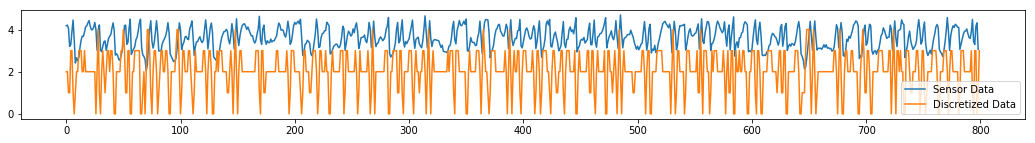

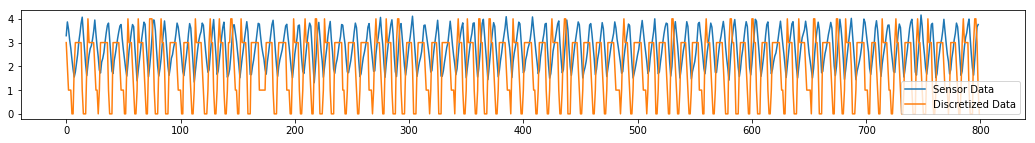

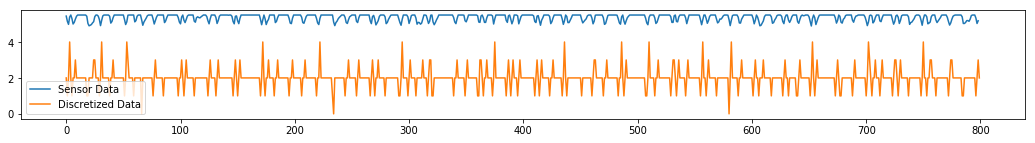

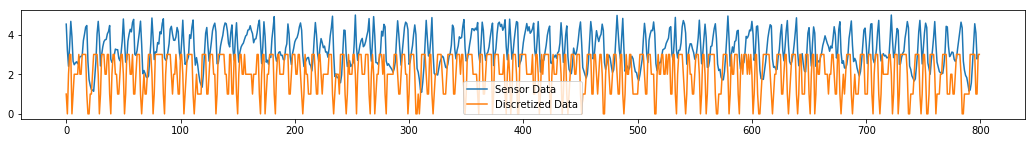

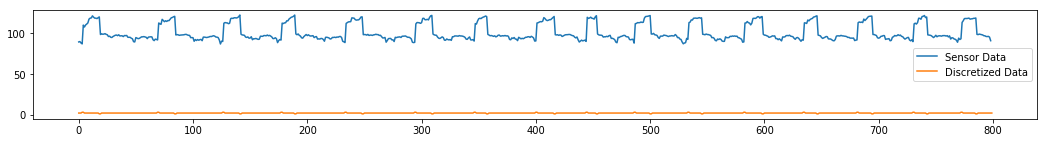

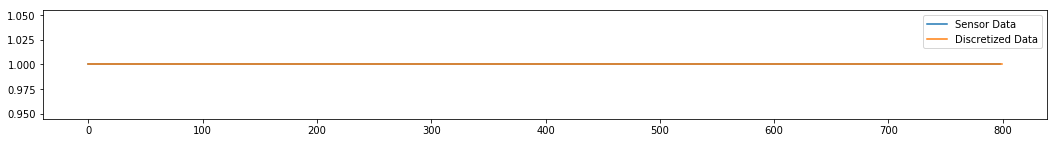

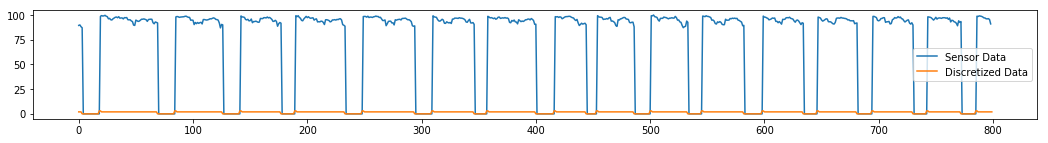

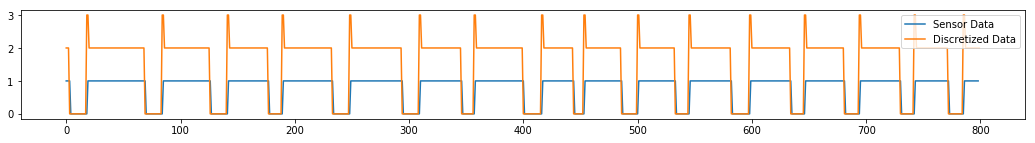

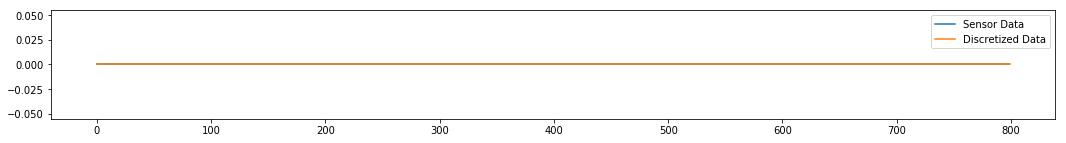

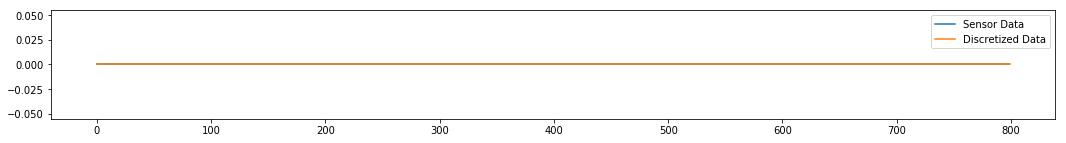

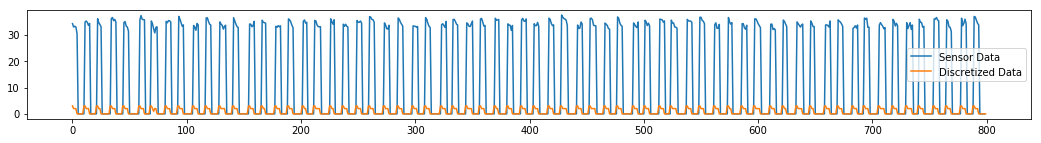

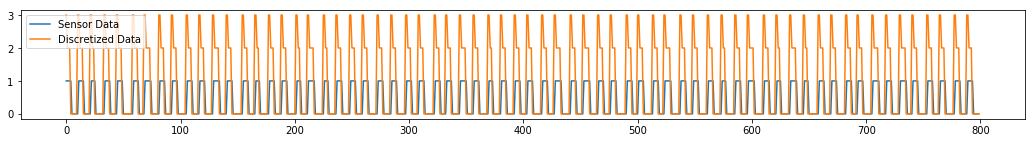

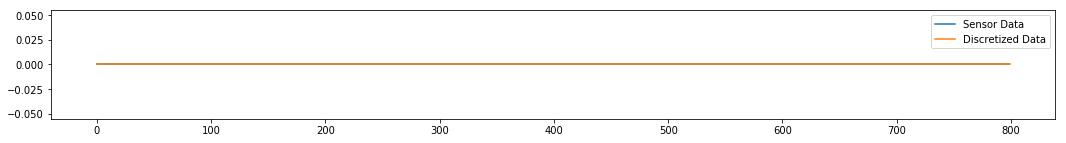

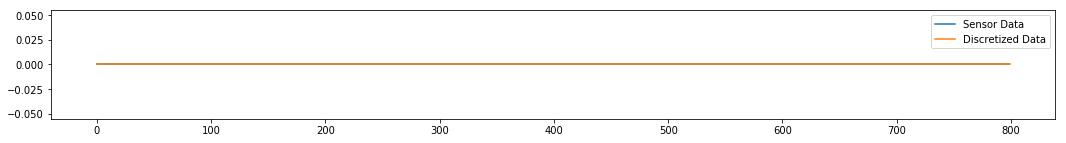

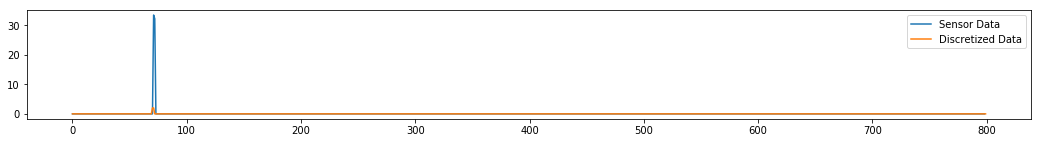

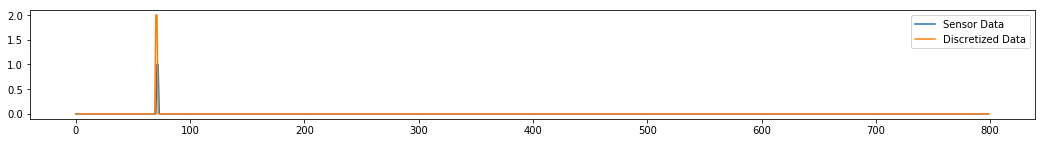

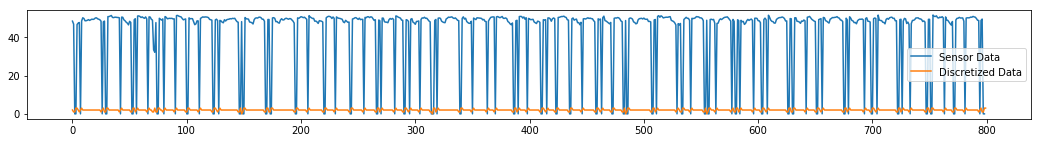

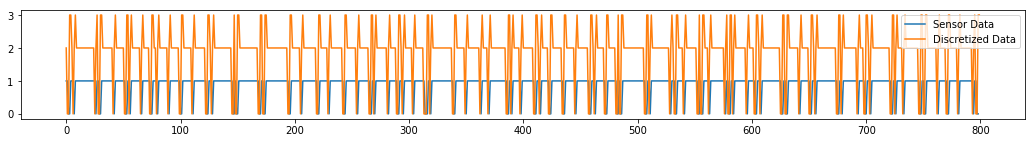

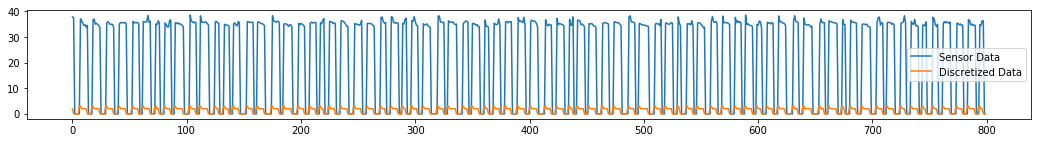

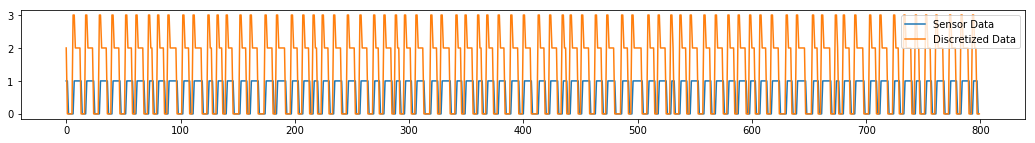

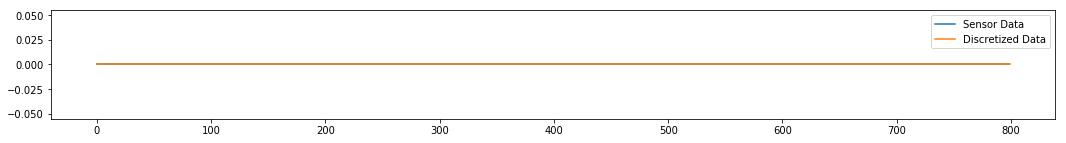

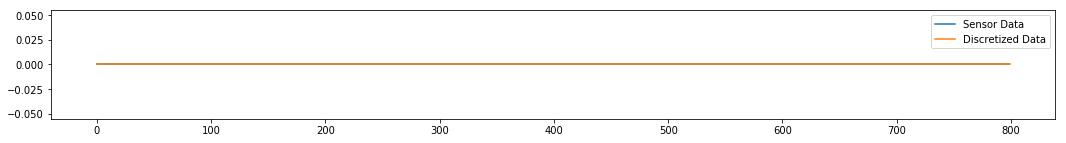

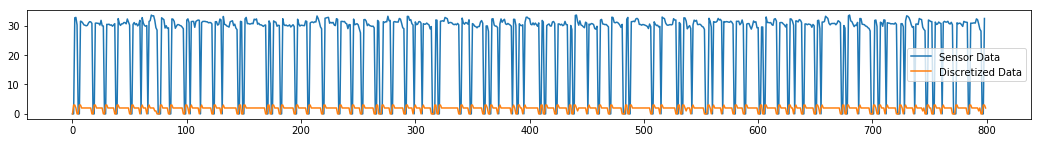

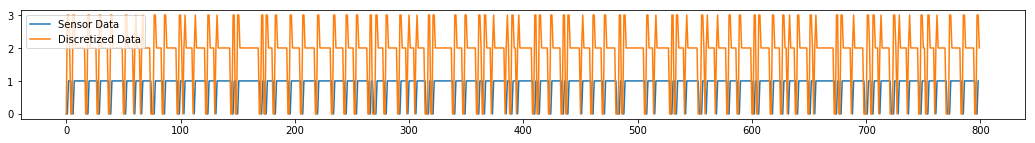

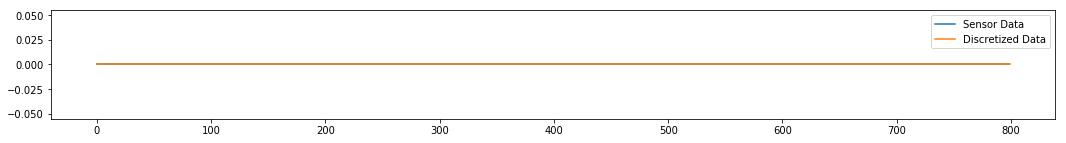

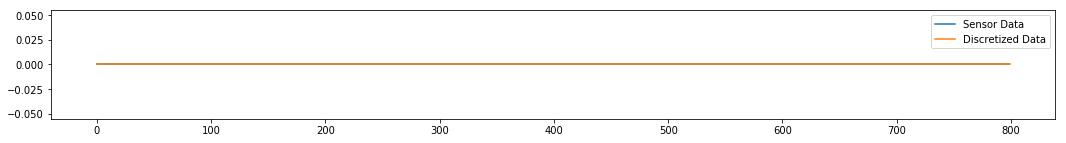

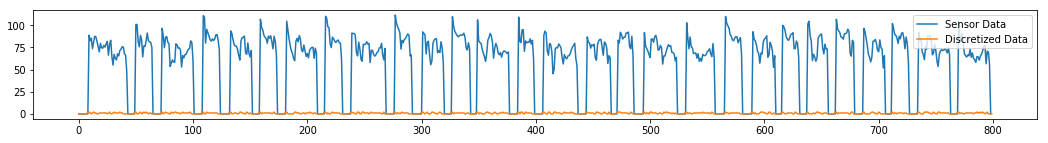

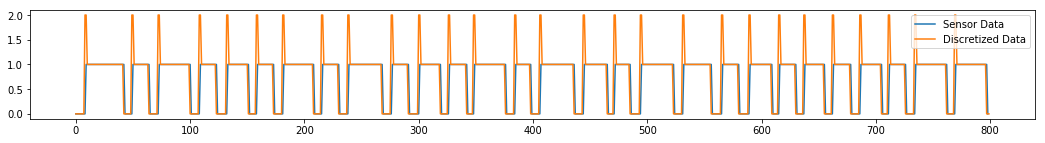

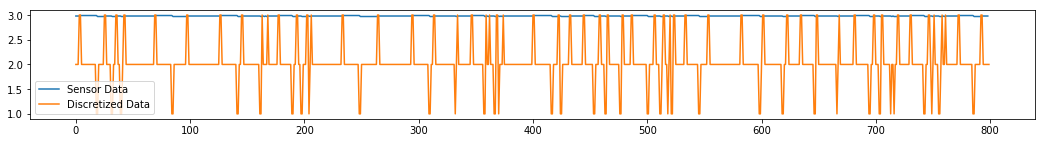

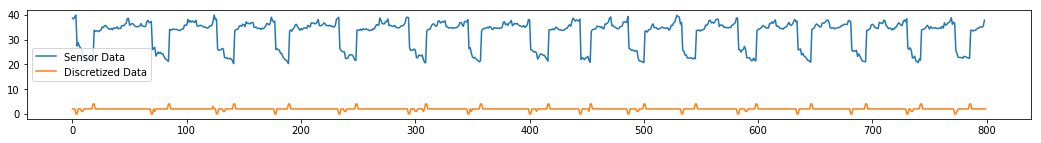

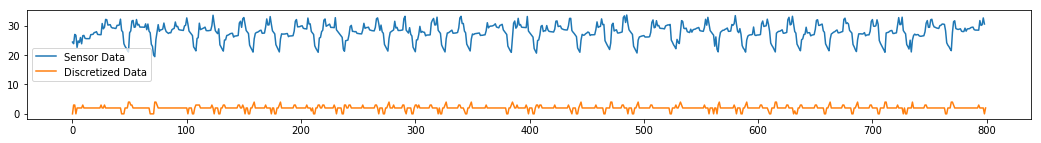

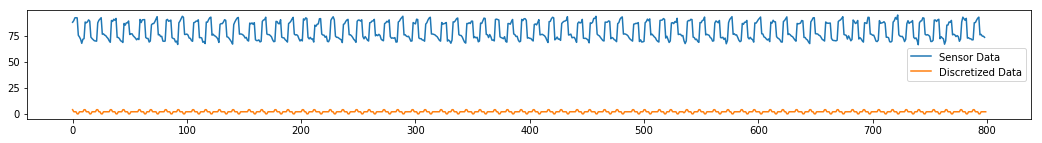

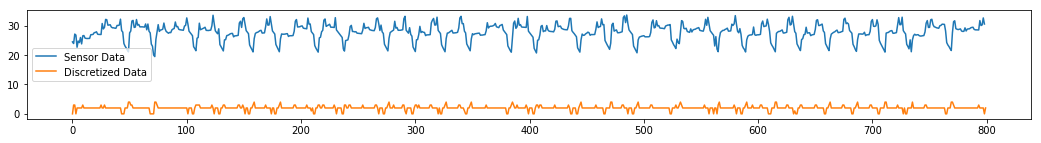

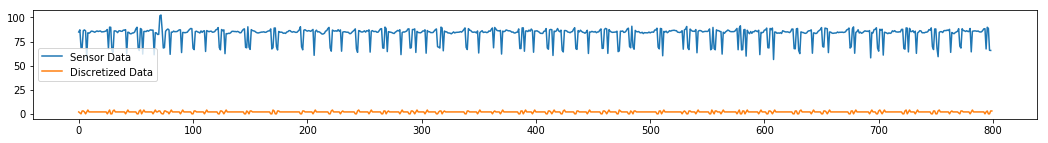

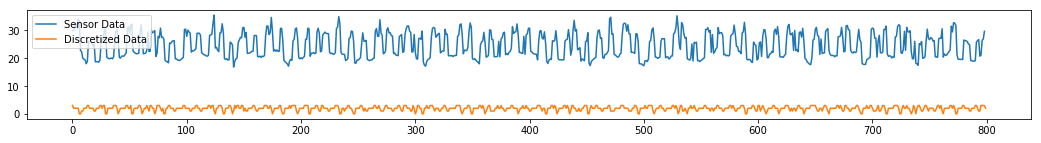

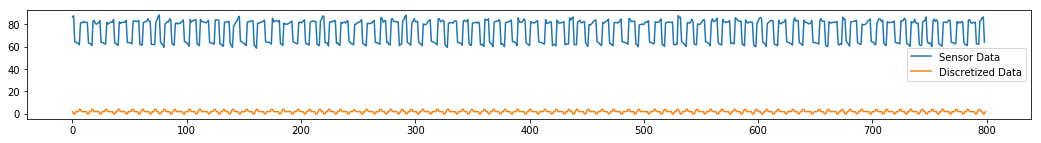

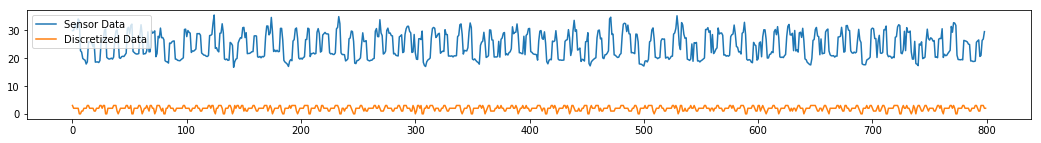

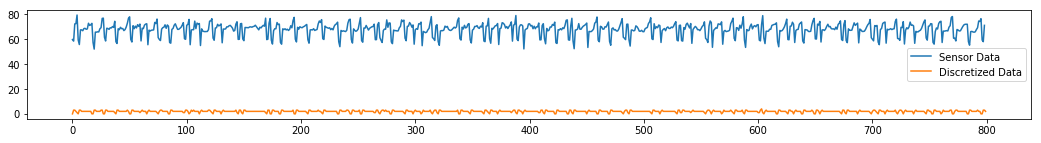

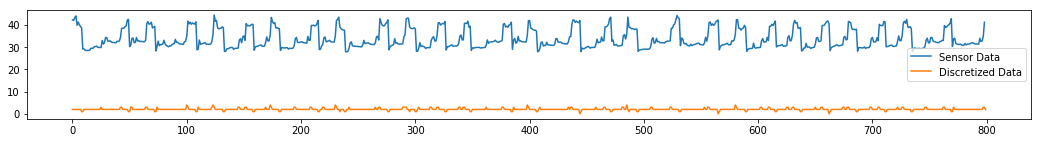

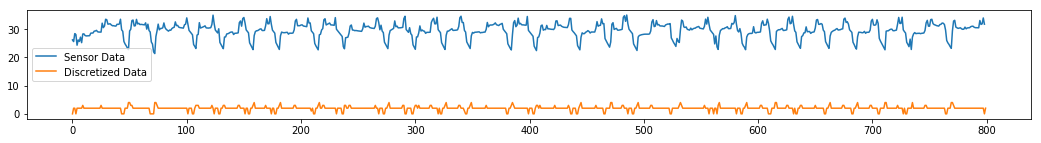

In [130]:
#Use change point detection to discretize based on percent change over given number of periods 
#Results are mapped to descrete values based on threshold value  and range of the data
#x: sensor data
#n: amount of datapoints
#m: amount of sensors
#p: number of periods
#t: threshold values
def discretize_sensors(x,n,m,p,t):
    disc_sensors = []
    for j in range(0,m):
        #Convert sensor data to percentile change
        sensor_data = x[:,j]
        s = pandas.Series(sensor_data)
        changes = s.pct_change(periods=p).values[p:-1]
        max_v = max(changes)
        min_v = min(changes)
        pos_t = t*max_v
        neg_t = t*min_v
        disc = (changes > pos_t).astype(int) + (changes > 0.1).astype(int) + (changes > -0.1).astype(int) +(changes > neg_t).astype(int) 
        disc_sensors.append(disc)
    return disc_sensors

#Show results for different values for parameters t and p
def test_parameters_disc(x,n,m):
    for p in range(1,10):
        for t in [.25, 0.5, 0.75]:
            disc_sensors = discretize_sensors(x,n,m,p,t)
            plt.figure(figsize=(18,2))
            plt.title("p=%d, t=%f"%(p,t))
            plt.plot(x[1:800,0])
            plt.plot(disc_sensors[0][0:800])

            
(x, y, n, m) = convert_df(df_2, norm=False)
#test_parameters_disc(x,n,m)            

t = 0.5
p = 2
disc_sensors = discretize_sensors(x,n,m,p,t)

#Plot all sensor data
for i in range(0,43):
    plt.figure(figsize=(18,2))
    plt.plot(x[1:800,i])
    plt.plot(disc_sensors[i][0:800])
    plt.legend(["Sensor Data", "Discretized Data"],loc=0)
    

In [138]:
#Find best values for threshold and sliding windows
#disc_sensors: List of discretized sensor values
def test_params_ngram(disc_sensors):
    #Define candidate thresholds and sliding windows
    cand_t = 10.**np.asarray(range(-30,-20))
    cand_sw = range(8,13)
    results = np.zeros((len(cand_t), len(cand_sw)))
    #Only optimize for first sensor, as each sensor has a different optimum
    disc = disc_sensors[0]
    t = 0
    for threshold in cand_t:
        sw = 0
        for sw_size in cand_sw:
            #Save the amount of alerts triggered by the sensor for given sliding window
            alerts = ngram_disc_sensor(disc, sw_size,threshold)
            results[t,sw] = len(alerts)
            sw = sw+1
        t = t+1
    return results

#Use bigram/ngram based Markov Chain on a discretized sensor
#disc: Discretized values for a single sensor
#sw_size: size of sliding window
#threshold: threshold of propability of sequence occusing for raising alarm
#disc_test: test sensor, by default the same as the train sensor data
def ngram_disc_sensor(disc, sw_size, threshold, disc_test=None):
    if disc_test==None:
        disc_test= disc
    #Define the possible states
    states = ["QD", "SD", "C", "SU", "QU"]
    #Map the numerical values to the states
    disc_states = []
    disc_test_states= []
    for state in disc:
        disc_states.append(states[state])
    for state in disc_test:
        disc_test_states.append(states[state]) 
        
    #Create a list of all bigrams in the state sequence
    bi_grams = list(ngrams(disc_states, 2))
    test_bigrams = list(ngrams(disc_test_states, 2))
    #Create a list of all possible bigrams
    comb_states = []
    for state_1 in states:
        for state_2 in states:
            pair = (state_1, state_2)
            comb_states.append(pair)
    #Create a from->to transition pair for each bigram in the state sequence
    comb_bi_grams = ngrams(bi_grams, 2)
    test_comb_bi_grams = ngrams(test_bigrams, 2)

    #Init transition matrics and smoothing factor
    a = 1/len(comb_states)**2
    p_dict = {}
    p_dict_start = {}

    #Smoothe and initialize the transition matrix and init matrix
    for state in comb_states:
        p_dict[state] = {}
        p_dict_start[state] = 1
        for to_state in comb_states:
            p_dict[state][to_state] = 1

    #Add all starting states to init matrix
    total_init = 0
    for state in bi_grams:
        p_dict_start[state] = p_dict_start[state]+1
        total_init = total_init +1    
    total_init = total_init + len(comb_states)

    #Add all transition pairs to transition matrix
    for pair in comb_bi_grams:
        (src, dest)= pair
        p_dict[src][dest] = p_dict[src][dest]+1

    #Normalize both matrics
    for src in comb_states:
        p_dict_start[src] = p_dict_start[src]/total_init
        total_trans = 0
        for dest in comb_states:
            total_trans = total_trans + p_dict[src][dest]
        for dest in comb_states:
            p_dict[src][dest] = p_dict[src][dest]/total_trans

    
    n = len(test_bigrams)  
    alerts = []
    #Iterate over all sliding windows and calculate the probability of the sequence in the sliding window 
    #according to the Markov matrics
    for i in range(0,n-sw_size):
        slc = test_bigrams[i:i+sw_size]
        p = p_dict_start[slc[0]]
        trans = ngrams(slc, 2)
        for transition in trans:
            (src, dst) = transition
            p = p * p_dict[src][dest] 
        #If the probability is too small, raise an alarm by adding the window to list of alerst
        if p < threshold:
            alerts.append((i, i+sw_size))
            #print(p)
    return alerts

#Test possible values for sliding window size and threshold
res = test_params_ngram(disc_sensors)
print(np.array(res))

#Init params 
n=len(disc_sensors[0])
m= len(disc_sensors)
sw_size =10 
threshold = 10**-28 
alerts = []

#Get the alerts for each sensor using the bigram Markov chain
for i in range(0,m):
    disc = disc_sensors[i]
    alert = ngram_disc_sensor(disc, sw_size,threshold)
    print(len(alert))
    alerts.append(alert)
    
# Only select sensors with less then 200 alerts    
idxs = np.array(list(map(len, alerts))) < 200
accurate_alerts = np.array(alerts)[idxs]


[[   0.    0.    0.  838. 3183.]
 [   0.    0.    0. 2301. 3521.]
 [   0.    0.  140. 2969. 3797.]
 [   0.    0. 1046. 3299. 3891.]
 [   0.    0. 2523. 3648. 3963.]
 [   0.  186. 3131. 3855. 4053.]
 [   0. 1290. 3463. 3942. 4104.]
 [   0. 2715. 3751. 4004. 4139.]
 [ 252. 3330. 3919. 4085. 4149.]
 [1541. 3586. 3985. 4125. 4151.]]
140
35
0
0
0
1957
1
3145
4163
2778
2793
4163
4163
1238
1242
4163
4163
4041
4040
1235
1293
332
335
4163
4163
926
1027
4104
4104
372
2591
2803
2703
2088
33
2090
1199
0
10
0
701
2350
1927


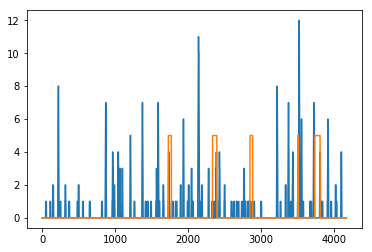

In [139]:
#Map the sliding windows which triggered an alert to the datapoints and aggregate all datapoints
hits = np.zeros(n)
for alert in accurate_alerts:
    for pair in alert:
        (first, last) = pair
        np.add.at(hits,range(first, last),1)
#Plot the aggregated data
plt.plot(hits)
#Plot the (labeled) attacks
plt.plot(y*5)